In [6]:
# %%
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
SIM_TIME = 1000000 # total sim duration
ARRIVAL_RATE = 1/10.0 # fixed average interarrival time
BUFFER_SIZE = 10
# BUFFER_SIZE = 6
SERVICE_RATES = [round(x, 2) for x in np.linspace(0.08, 0.25, 18)]  # service rates μ
SEED = 42 # for reproducible randomness
TYPE1 = 1 # identify the client 


In [10]:
class Measure:
    def __init__(self):
        self.arr = 0        # total arrivals
        self.dep = 0        # total departures
        self.ut = 0         # cumulative users*time (for avg users)
        self.oldT = 0       # last event time (for ∆t calculations)
        self.delay = 0      # total time spent in system
        self.bs1 = 0        # server 1 busy time
        self.bs2 = 0        # server 2 busy time
        self.loss = 0       # total lost packets


In [11]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

- both arrival and departure simulate behavior differently for shared and separate buffers 
- shared => one global queue MM1 => two servers can pick from it 
- Separate => two independent queues MM1 and MM2 => assigned randomly  

In [14]:
def simulate_fixed_arrival(service_time, shared=True):
    global users, data, MM1, MM2, busy1, busy2
    users = 0 #represent the total packets in the system
    data = Measure()
    MM1 = []
    MM2 = []
    time = 0
    busy1 = False
    busy2 = False

    FES = PriorityQueue() #future event set - priority queue of events
    random.seed(SEED)
    # here in arrival we update arrival stats , schedule the next arrvial 
    # place client in buffer if it is not full
    # if server is free, immediatelty serve 
    def arrival(current_time):
        global users, busy1, busy2
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL_RATE)
        FES.put((current_time + inter_arrival, "arrival"))

        if shared:
            if users < BUFFER_SIZE:
                users += 1
                client = Client(TYPE1, current_time)
                MM1.append(client)

                if not busy1:
                    currentservice_time = random.expovariate(1/service_time)  # new: service_rate = μ
                    data.bs1 += currentservice_time
                    FES.put((current_time + currentservice_time, "departure1"))
                    busy1 = True
                elif not busy2:
                    currentservice_time = random.expovariate(1/service_time)  # new: service_rate = μ
                    data.bs2 += currentservice_time
                    FES.put((current_time + currentservice_time, "departure2"))
                    busy2 = True
            else:
                data.loss += 1
        else:
            target = 1 if random.random() < 0.5 else 2
            buffer_limit = BUFFER_SIZE
            if target == 1:
                if len(MM1) < buffer_limit:
                    MM1.append(Client(TYPE1, current_time))
                    users += 1
                    if not busy1:
                        currentservice_time = random.expovariate(1/service_time) 
                        data.bs1 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure1"))
                        busy1 = True
                else:
                    data.loss += 1
            else:
                if len(MM2) < buffer_limit:
                    MM2.append(Client(TYPE1, current_time))
                    users += 1
                    if not busy2:
                        currentservice_time = random.expovariate(1/service_time) 
                        data.bs2 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure2"))
                        busy2 = True
                else:
                    data.loss += 1

    # remove one client 
    # update delay and usage stats 
    # if queue has more, start next service 
    # if queue is empty, mark server as idle 

    def departure(current_time, server_id):
        global users, busy1, busy2
        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        if shared:
            if MM1:
                client = MM1.pop(0)
                data.delay += (current_time - client.arrival_time)
                users -= 1
                if MM1:
                    currentservice_time = random.expovariate(1.0 / service_time)
                    if server_id == 1:
                        data.bs1 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure1"))
                    else:
                        data.bs2 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure2"))
                else:
                    if server_id == 1:
                        busy1 = False
                    else:
                        busy2 = False
        else:
            # each server has its own queue like MM1 and MM2 
            target_queue = MM1 if server_id == 1 else MM2
            if target_queue:
                # 
                client = target_queue.pop(0)
                # calculate how much the client waited - now - arrival time 
                data.delay += (current_time - client.arrival_time)
                users -= 1
                # after popping the client we check if there are more waiting in the server's queue
                # if true => start the next service immediately 
                # if false => mark the server as idle
                if target_queue:
                    # generate a random service time for the next client
                    # scehdule the future event for new client being served 
                    # also track busy time for this server (accumulate bs1 or bs2)
                    currentservice_time = random.expovariate(1.0 / service_time)
                    if server_id == 1:
                        data.bs1 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure1"))
                    else:
                        data.bs2 += currentservice_time
                        FES.put((current_time + currentservice_time, "departure2"))
                else:
                    if server_id == 1:
                        busy1 = False
                    else:
                        busy2 = False

    FES.put((0, "arrival"))
    while time < SIM_TIME:
        (time, event_type) = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * 2)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0

    return delay, avg_users, utilization, loss_rate

# %%
# Run the simulation for various service rates
results = []

for servicetime in SERVICE_RATES:
    shared_metrics = simulate_fixed_arrival(1/servicetime, shared=True)
    separate_metrics = simulate_fixed_arrival(1/servicetime, shared=False)
    results.append({
        'Service Rate': servicetime,
        'Type': 'Shared',
        'Avg Delay': shared_metrics[0],
        'Avg Users': shared_metrics[1],
        'Utilization': shared_metrics[2],
        'Loss Rate': shared_metrics[3]
    })
    results.append({
        'Service Rate': servicetime,
        'Type': 'Separate',
        'Avg Delay': separate_metrics[0],
        'Avg Users': separate_metrics[1],
        'Utilization': separate_metrics[2],
        'Loss Rate': separate_metrics[3]
    })


KeyboardInterrupt: 

In [25]:
# %%
# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


    Service Rate      Type  Avg Delay  Avg Users  Utilization  Loss Rate
0           0.08    Shared  12.521050   1.248961     0.279820   0.002071
1           0.08  Separate  12.536072   1.247639     0.384618   0.000060
2           0.09    Shared  11.237509   1.120704     0.264748   0.001482
3           0.09  Separate  11.125098   1.110382     0.358435   0.000050
4           0.10    Shared  10.176500   1.016593     0.253131   0.001080
5           0.10  Separate  10.043148   1.001452     0.334464   0.000000
6           0.11    Shared   9.183807   0.913688     0.239657   0.000372
7           0.11  Separate   9.122461   0.909905     0.313135   0.000010
8           0.12    Shared   8.463936   0.846216     0.230081   0.000470
9           0.12  Separate   8.340372   0.831554     0.294474   0.000010
10          0.13    Shared   7.793699   0.778885     0.219092   0.000160
11          0.13  Separate   7.691603   0.766183     0.277542   0.000010
12          0.14    Shared   7.263302   0.724597   

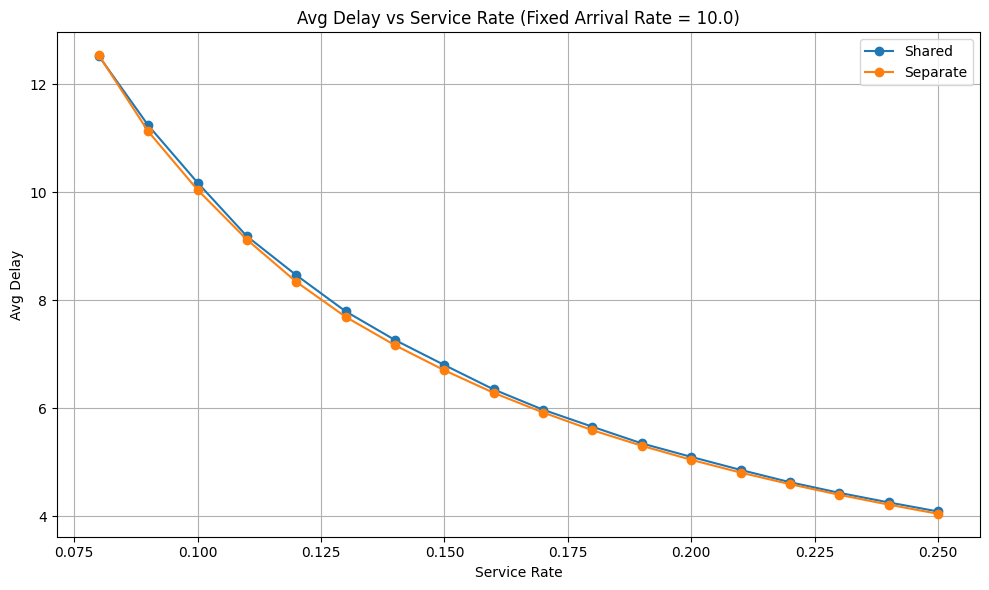

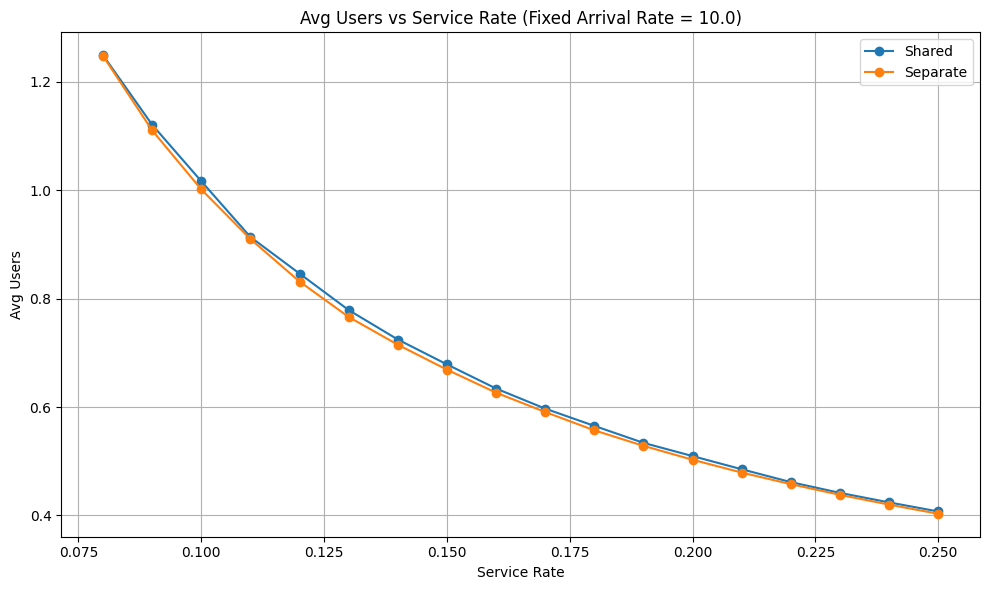

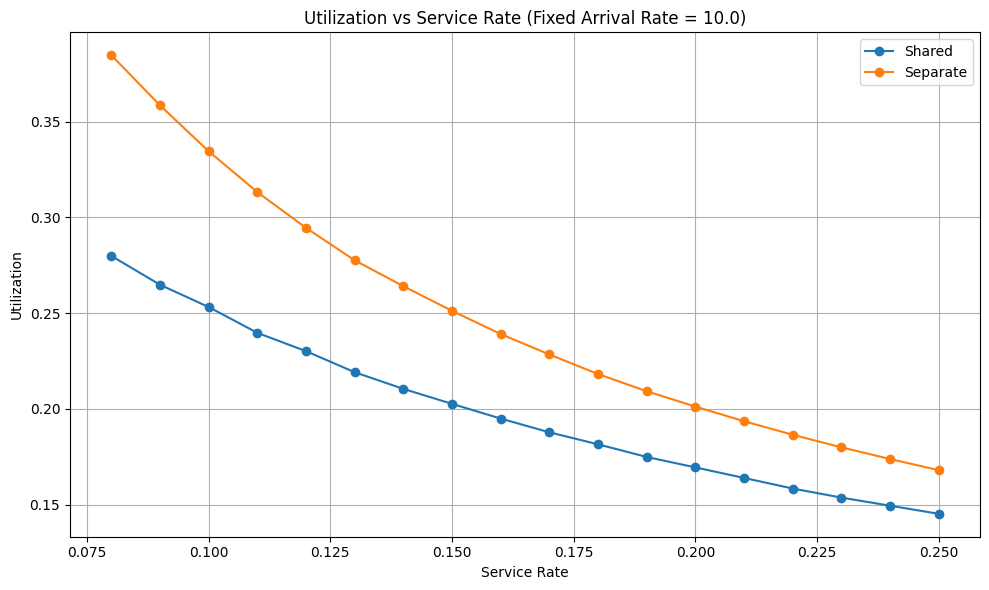

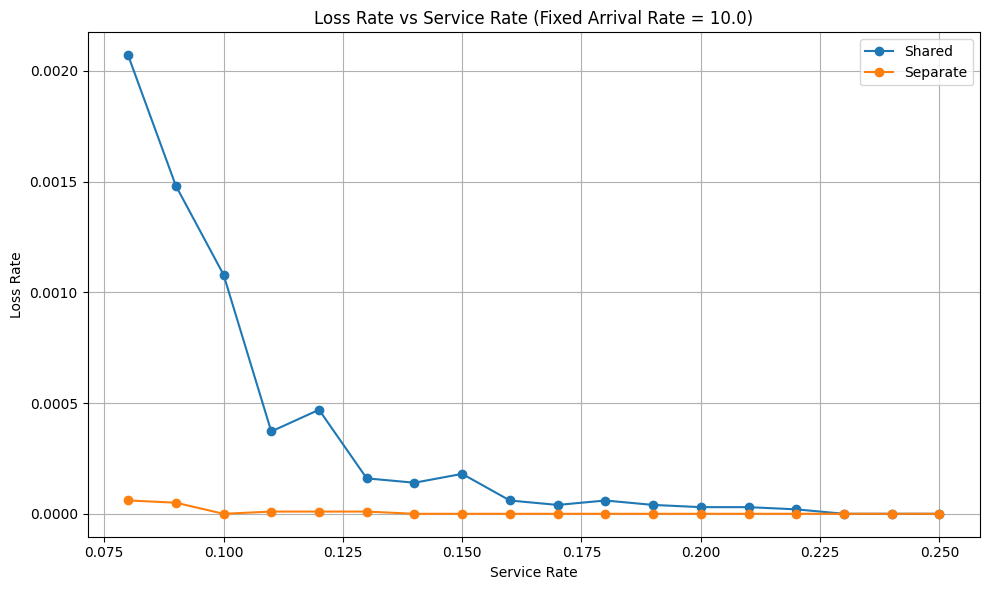

In [26]:
# %%
# Plot the results
metrics = ['Avg Delay', 'Avg Users', 'Utilization', 'Loss Rate']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for t in ['Shared', 'Separate']:
        vals = results_df[results_df['Type'] == t]
        plt.plot(vals['Service Rate'], vals[metric], marker='o', label=t)
    plt.title(f'{metric} vs Service Rate (Fixed Arrival Rate = {ARRIVAL_RATE})')
    plt.xlabel('Service Rate')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 1 chart : Avg Delay vs Service rate (shared vs Separate Buffer)- fixed arrival rate = 10 

- a shared finite buffer and separate finite buffers (one per servre)
- the arrival rate is fixed while the service rate μ was varied to analyze its impact on average system delay. 
- the result show an inverse relationship btw service rate and average delay - as service rate increased, the avg delay decreased consistently for both config 
- this alligns with the queuing theory expectations, as faster servers, reducing congestion
- both systems behave nearly identical across all tested values of μ
- implies that under balanced and stable load => the choice of buffer architecture has mini effect on delay performance  

# Average Users VS Service Rate 

- the result confirms thate increasing the service rate significantly reduces the avg number of users in the system

- this is also consistent with the queueing theory where faster servers reduce waiting time and queue build up

- across all service rates => the shared buffer system maintained slightly higher occupancy than the separate buffer system, particularly at lower service rates 

- likely due to the centralized nature of the shared buffer which can accomodate more users before losing them 


# Utilization VS Service rate 

- Utilization defined as the fraction of time servers are busy, shows a decreasing trend as the service rate increases 

- this is expected as fater server completes the job leading to the more idle time and reduce cumulative utilization 

- the separate buffer config consistently exhibits higher utilization than the shared buffer setup acorss all service rates.

- in separate systems => each server independently stays active when the overall system load is light 

- shares buffer may occasionally underutilize the one server if load balancing is uneven 

- overall, both systems become less utilized at higher service rates, but the separate config maintain slightly more balanced workload per server


# Loss rate VS Service rate 

- loss rate sharply decreases at higher service rates since faster servers can process packets before buffer overflows 

- shared buffer expricence higher loss rate at lower service rates
- bc both servers drawn from the same limited space 

- the separate buffer setup maintain almost negligible loss rate across all tested service rates => more efficient handling of traffic by isolating queue overflow risks 

- separate buffers offer greater resilience to the packet loss, especially when the service capacity is limited 

*** if both servers are busy and the buffer is full => every new arrival is lost in the shared buffer 

*** but in separate buffer => overflow in one doesn't effect the other and it cajn serve the new arrival 